# Spatial Interpolation with ESI on Gridded Data

Spatialize supports two formats formats for input data. This document provides an overview on the basic implementation for gridded data.

In [1]:
# === Libraries ===
import sys
sys.path.append('../')
from utils import SyntheticScenario

import numpy as np
from matplotlib import pyplot as plt

import spatialize.gs.esi.aggfunction as af
from spatialize.gs.esi import esi_griddata
from sklearn.metrics import mean_absolute_error


## Gridded data

The **`esi_griddata()`** function is designed to produce estimations over a dense mesh-grid (i.e. a tuple or array of regular arrays).
In the 2-D scenario, the shape of this array is $(2 \times N_x \times N_y)$, while in the 3-D scenario it is of shape $(3 \times N_x \times N_y \times N_z)$, where $N_x$, $N_y$, and $N_z$ are the number of points or grid cells in the X, Y and Z axes, respectively.

Therefore, for a D-dimensional scenario, we would produce estimates over an array of size $(D \times N_1 \times \cdots \times N_D)$.

The `mgrid()` function from the numpy library can be used to generate a grid of such characteristics, as follows:

In [2]:
# 2-D grid generation: 100x150 grid 
xi_2d = np.mgrid[1:100:100j, 1:150:150j]

# 3-D grid generation: 100x150x30 grid
xi_3d = np.mgrid[1:100:100j, 1:150:150j, 1:30:30j]

We can corroborate the shape of these grids is $(D \times N_1 \times \cdots \times N_D)$:

In [3]:
xi_2d.shape

(2, 100, 150)

In [4]:
xi_3d.shape

(3, 100, 150, 30)

> Note: Currently suported local interpolator-partition process combinations for gridded data are:
- 'idw' as local interpolator and 'mondrian' as partition process supports up to 3-dimensional data
- 'idw' as local interpolator and 'voronoi' as partition process supports 2-dimensional data
- 'adaptiveidw' as local interpolator and 'mondrian' as partition process supports up to 3-dimensional data
- 'kriging' as local interpolator and 'mondrian' as partition process supports 3-dimensional data

## Producing ESI Estimates Over a Grid
We will now generate ESI estimates for two synthetic scenarios: one in 2D and one in 3D.

### Creating Synthetic Scenarios
We'll use a sort of cubic function to generate synthetic samples.

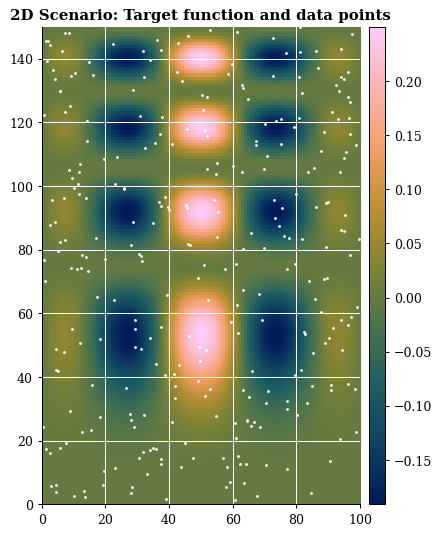

In [5]:
# === 2D Scenario (a)===
scenario_2d = SyntheticScenario(n_dims=2, extent=[0, 100, 0, 150], griddata=True)
points_2d, values_2d, xi_2d, reference_values_2d = scenario_2d.simulate_scenario(n_samples=300, seed=42)

# Visualize reference values and samples
scenario_2d.plot_2d_scenario(points_2d, xi_2d, reference_values_2d,
                             theme='publication', cmap='batlow', figsize=(5, 8), dpi=90,
                             title='2D Scenario: Target function and data points')
plt.tight_layout()
plt.show()

# === 3D Scenario=== 
scenario_3d = SyntheticScenario(n_dims=3, extent=[0, 100, 0, 150, 0, 30], griddata=True)
points_3d, values_3d, xi_3d, reference_values_3d = scenario_3d.simulate_scenario(n_samples=300, seed=42)


### Producing Estimates

Next, we employ the ``esi_griddata`` function to produce the estimates. Here, we will use inverse distance weighting (IDW) as local interpolator.

In [6]:
result_2d = esi_griddata(points_2d, values_2d, xi_2d,
                         local_interpolator="idw",
                         p_process="mondrian",
                         exponent=1.0,
                         n_partitions=300, alpha=0.985,
                         agg_function=af.mean
                         )

esi_est_2d = result_2d.estimation()

finished 100% of 300 iterations ... 

done (elapsed time:  4s)


We can quickly visualize the results with the `quick_plot()` method:

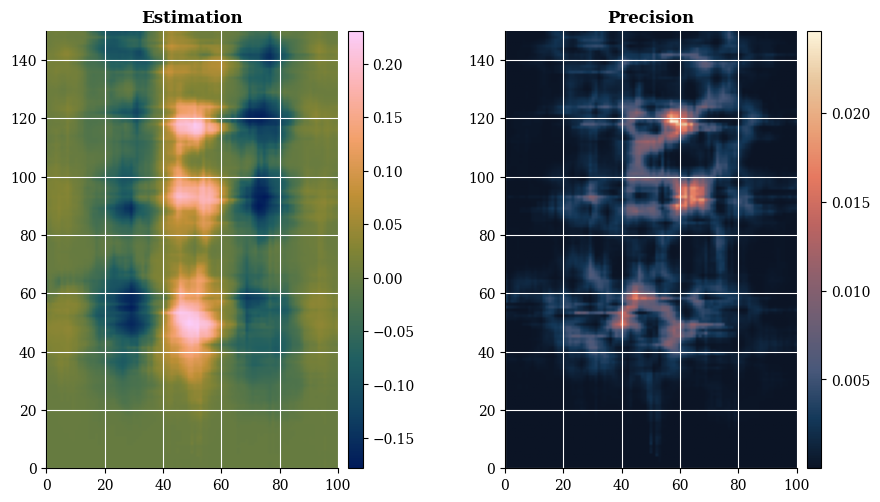

In [7]:
result_2d.quick_plot(theme='publication', estimation_cmap='batlow', precision_cmap='lipari', dpi = 100)
plt.show()

Since we are using synthetic data, we can calculate performance metrics between the reference values and the estimated values:

In [8]:
print(f"MAE = {mean_absolute_error(reference_values_2d, esi_est_2d):.4f}")

MAE = 0.0189


Now, we will produce estimates for the 3D scenario.

In [9]:
result_3d = esi_griddata(points_3d, values_3d, xi_3d,
                         local_interpolator="idw",
                         p_process="mondrian",
                         exponent=1.0,
                         n_partitions=100,
                         alpha=0.8)

esi_est_3d = result_3d.estimation()


finished 100% of 100 iterations ... 

done (elapsed time: 42s)


> Note: The ``quick_plot()`` method is not supported for 3D data.

Finally, we calculate the mean absolute error:

In [10]:
print(f"MAE = {mean_absolute_error(reference_values_3d.flatten(), esi_est_3d.flatten()):.4f}")

MAE = 0.0289
